![](pics\task2_1.jpg)
![](pics\task2_2.jpg)
![](pics\task2_3.jpg)
![](pics\task2_4.jpg)
![](pics\task2_5.jpg)
![](pics\task2_6.jpg)

In [2]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

## MAKE_FRIEDMAN2

In [3]:
from sklearn.datasets import make_friedman2
x, y = make_friedman2()

### 1. Візуалізація даних

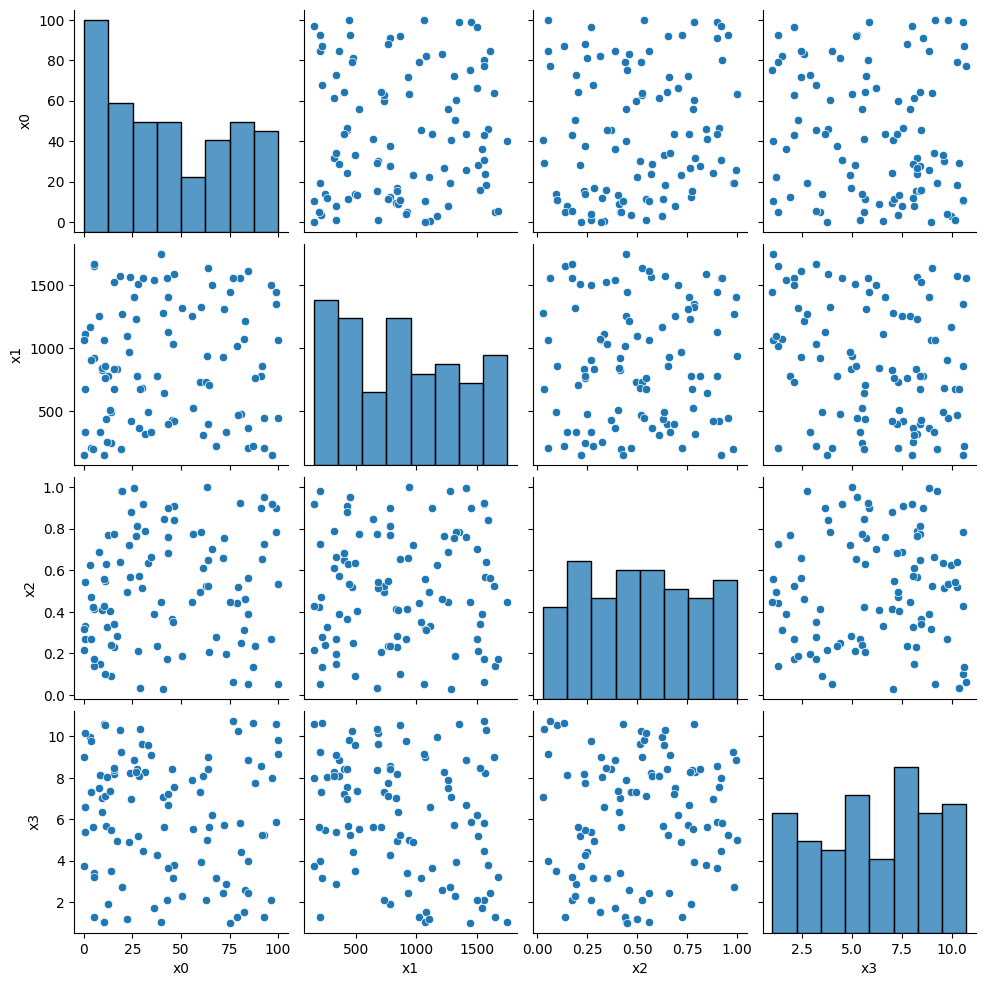

In [4]:
df = pd.DataFrame(x, columns=['x0', 'x1', 'x2', 'x3' ])

sns.pairplot(df)

### 2.Розбиття даних на набори

In [5]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=1, train_size=0.8)

### 3.Побудова моделей

In [6]:
from sklearn.svm import SVR

linModel = SVR(kernel='linear')
polyModel = SVR(kernel="poly")
rbfModel = SVR(kernel="rbf")

models = [linModel, polyModel, rbfModel]

for model in models:
    model.fit(xtrain, ytrain)

### 1.4 Прогнози на побудованих моделях

In [7]:
train_preds = []
test_preds = []
for model in models:
    train_preds.append(model.predict(xtrain))
    test_preds.append(model.predict(xtest))

### 1.5 Визначення метрик

In [8]:
from math import ceil
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def print_result(models, train_preds, val_pred, y_train, y_val, with_model_names = True):
 
    metrics = [r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error]
    metrics_values = []
    for i in range(len(models)):
        lst = []
        for metric in metrics:
            lst.append(metric(ytrain, train_preds[i]))
            lst.append(metric(ytest, test_preds[i]))
        metrics_values.append(lst)

    for i in range(len(models)):
        if with_model_names:
            n = ceil( (35 - len(str(models[i])))/2 )
            print("="*n + str(models[i]) + "="*n)
        print(" train_set test_set")
        print("R^2:" + " "*6 + f"{round(metrics_values[i][0],5)}" + " "*7 + f"{round(metrics_values[i][1], 4)}")
        print("MAE:" + " "*6 + f"{round(metrics_values[i][2],5)}" + " "*7 + f"{round(metrics_values[i][3], 4)}")
        print(f"MAPE:" + " "*5 + f"{round(metrics_values[i][4],5)}" + " "*7 + f"{round(metrics_values[i][5], 4)}")
        len_ = 7 + 7 - len(str(round(np.sqrt(metrics_values[i][4]), 4)))
        print(f"RMSE:" + " "*5 + f"{round(np.sqrt(metrics_values[i][6]), 4)}" + " "*len_ + 
           f"{round(np.sqrt(metrics_values[i][7]), 4)}")
        print()
        
 
 
print_result(models, train_preds, test_preds, ytrain, ytest)

========SVR(kernel='linear')========
 train_set test_set
R^2:      0.43519       0.4819
MAE:      197.64765       179.3352
MAPE:     0.72289       0.6913
RMSE:     282.7088        223.6666

=========SVR(kernel='poly')=========
 train_set test_set
R^2:      0.19191       0.0687
MAE:      244.91736       222.1675
MAPE:     0.94595       0.7883
RMSE:     338.158        299.8745

===============SVR()===============
 train_set test_set
R^2:      -0.05468       -0.2582
MAE:      274.58669       257.2004
MAPE:     1.06868       0.9358
RMSE:     386.3218        348.5587



### 1.6 Решітчастий пошук для налаштування гіперпараметрів моделей

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid_for_svr_linear = {"C": [0.1, 0.5, 1, 5, 10, 100], 
    "epsilon": [1e-2, 0.1, 0.5, 1, 5]}
param_grid_for_svr_rbf = {"C": [0.1, 0.5, 1, 5, 10, 100],
    "epsilon": [1e-2, 0.1, 0.5, 1, 5]
}
param_grid_for_svr_poly = {"C": [0.1, 0.5, 1, 5, 10, 100],
    "epsilon": [1e-2, 0.1, 0.5, 1, 5], 
        "degree": [2, 3, 5, 10]
}
gs_svr_linear = GridSearchCV(linModel, param_grid_for_svr_linear, cv = 3,
    scoring = "neg_root_mean_squared_error")
gs_svr_rbf = GridSearchCV(rbfModel, param_grid_for_svr_rbf,
    scoring = "neg_root_mean_squared_error")
gs_svr_poly = GridSearchCV(polyModel, param_grid_for_svr_poly,
    scoring = "neg_root_mean_squared_error")


In [13]:
def dict_sort(dict_, k = -1):

    dict_ = {"params": dict_["params"],
        "mean_test_score": k*dict_["mean_test_score"]}

    sorted_dict = {"params" : [],
        "mean_test_score": []}
    # сортуємо у порядку спадання:
    sorted_score_values = np.sort(dict_["mean_test_score"])
    for value in sorted_score_values:
        index = np.where(dict_["mean_test_score"] == value)[0][0]
        sorted_dict["params"].append(dict_["params"][index])
        sorted_dict["mean_test_score"].append(dict_["mean_test_score"][index])

    return sorted_dict

# функція для виводу результату решітчатого пошуку
def print_gs_results(results, first = -1, k = -1):

    gs_info = {"params": results['params'],
        "mean_test_score": results['mean_test_score'],}

    gs_info = dict_sort(gs_info, k)
    size = results["mean_test_score"].shape[0]

    for i in range(size):
        str_ = str(gs_info['params'][i])
        n = len(str_)
        spaces = (45 - n)*" "
        print(gs_info['params'][i], spaces, round(gs_info['mean_test_score'][i],4))

        # зупинка виводу, якщо задано параметр first
        if i == first - 1:
            break


### 1.6.1 Решітчастий пошук для SVR(kernel = 'linear')

In [14]:
gs_svr_linear.fit(xtrain, ytrain)
print_gs_results(gs_svr_linear.cv_results_, first = 9)

{'C': 100, 'epsilon': 5}                       195.0996
{'C': 100, 'epsilon': 0.01}                    197.0457
{'C': 100, 'epsilon': 0.1}                     197.0656
{'C': 100, 'epsilon': 1}                       197.1236
{'C': 100, 'epsilon': 0.5}                     197.1391
{'C': 10, 'epsilon': 5}                        267.2728
{'C': 10, 'epsilon': 1}                        267.6481
{'C': 10, 'epsilon': 0.5}                      267.7412
{'C': 10, 'epsilon': 0.01}                     267.7737


зберігаємо найкращу модель

In [19]:
best_svr_linear = gs_svr_linear.best_estimator_

### 1.6.2 Решітчастий пошук для SVR(kernel = "poly")

In [16]:
gs_svr_poly.fit(xtrain, ytrain)
print_gs_results(gs_svr_poly.cv_results_, first = 9)

{'C': 100, 'degree': 2, 'epsilon': 0.01}       300.1683
{'C': 100, 'degree': 2, 'epsilon': 0.1}        300.2363
{'C': 100, 'degree': 2, 'epsilon': 0.5}        300.5406
{'C': 100, 'degree': 2, 'epsilon': 1}          300.8346
{'C': 100, 'degree': 2, 'epsilon': 5}          301.7193
{'C': 10, 'degree': 2, 'epsilon': 0.01}        315.1264
{'C': 10, 'degree': 2, 'epsilon': 0.1}         315.1648
{'C': 10, 'degree': 2, 'epsilon': 0.5}         315.3368
{'C': 10, 'degree': 2, 'epsilon': 1}           315.5161


In [20]:
best_svr_poly = gs_svr_poly.best_estimator_

### 1.6.3 Решітчастий пошук для SVR(kernel = "rbf")

In [17]:
gs_svr_rbf.fit(xtrain, ytrain)
print_gs_results(gs_svr_rbf.cv_results_, first = 9)

{'C': 100, 'epsilon': 5}                       302.062
{'C': 100, 'epsilon': 1}                       302.1812
{'C': 100, 'epsilon': 0.01}                    302.1829
{'C': 100, 'epsilon': 0.1}                     302.1855
{'C': 100, 'epsilon': 0.5}                     302.1908
{'C': 10, 'epsilon': 0.01}                     354.9984
{'C': 10, 'epsilon': 0.1}                      355.0071
{'C': 10, 'epsilon': 0.5}                      355.0461
{'C': 10, 'epsilon': 1}                        355.0977


In [21]:
best_svr_rbf = gs_svr_rbf.best_estimator_

### 1.7 Вибір найкращої моделі

In [22]:
best_svr_linear.fit(xtrain, ytrain)
best_svr_poly.fit(xtrain, ytrain)
best_svr_rbf.fit(xtrain, ytrain)

final_train_preds = []
final_test_preds = []
best_models = [best_svr_linear, best_svr_poly, best_svr_rbf]
for model in best_models:
    final_train_preds.append(model.predict(xtrain))
    final_test_preds.append(model.predict(xtest))


In [24]:
first_models = [linModel, polyModel, rbfModel]
first_train_preds = []
first_test_preds = []
for model in first_models:
    first_train_preds.append(model.predict(xtrain))
    first_test_preds.append(model.predict(xtest))
    
print("моделі з стандартними параметрами:\n")
print_result(first_models, first_train_preds, first_test_preds, ytrain, ytest)
print("\n\nмоделі з підігнаними параметрами:\n")
print_result(best_models, final_train_preds, final_test_preds, ytrain, ytest)

моделі з стандартними параметрами:

========SVR(kernel='linear')========
 train_set test_set
R^2:      0.43519       0.4819
MAE:      197.64765       179.3352
MAPE:     0.72289       0.6913
RMSE:     282.7088        223.6666

=========SVR(kernel='poly')=========
 train_set test_set
R^2:      0.19191       0.0687
MAE:      244.91736       222.1675
MAPE:     0.94595       0.7883
RMSE:     338.158        299.8745

===============SVR()===============
 train_set test_set
R^2:      -0.05468       -0.2582
MAE:      274.58669       257.2004
MAPE:     1.06868       0.9358
RMSE:     386.3218        348.5587



моделі з підігнаними параметрами:

SVR(C=100, epsilon=5, kernel='linear')
 train_set test_set
R^2:      0.80178       0.4819
MAE:      118.54092       179.3352
MAPE:     0.49067       0.6913
RMSE:     167.4792        223.6666

SVR(C=100, degree=2, epsilon=0.01, kernel='poly')
 train_set test_set
R^2:      0.39624       0.0687
MAE:      211.47384       222.1675
MAPE:     0.8657       0.7883

### 1.8 Навчання моделі на підмножинах навчальних даних
за розміри підмножин навчального набору виберемо 20%, 40%, 60%, 80%

In [26]:
subsets_of_X_train = []
subsets_of_y_train = []
percentages = [0.2, 0.4, 0.6, 0.8]
for percentage in percentages:
    _, subset_of_X_train, _, subset_of_y_train = train_test_split(xtrain, ytrain, test_size = percentage,
    random_state = 42)
    subsets_of_X_train.append(subset_of_X_train)
    subsets_of_y_train.append(subset_of_y_train)


In [28]:
from sklearn.base import clone
final_model = SVR(C=10, epsilon=0.5, kernel='poly', degree = 3)
for i in range(len(subsets_of_X_train)):
    model = clone(final_model)
    model.fit(subsets_of_X_train[i], subsets_of_y_train[i])

    train_prediction = model.predict(subsets_of_X_train[i])
    val_prediction = model.predict(xtest)

    print(f"{int(percentages[i] * 100)}% від початкового набору:")
    print_result([model], [train_prediction], [val_prediction],subsets_of_y_train[i],
        ytest, with_model_names = False)

20% від початкового набору:


ValueError: Found input variables with inconsistent numbers of samples: [80, 16]

## 2. Tesla stock dataset

In [3]:
df = pd.read_csv(r'D:\Projects\IAD labs\IAD-labs\resourses\TSLA.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [45]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


Видаляємо колонку 'Adj Close' так як вона повністю повторює колонку 'Close', а також колонку з датами торгів, так як її, на мій погляд, нема сенсу використовувати у прогнозі.

In [8]:
df = df.drop(columns = ["Date", 'Adj Close'], axis = 1)

,Open,High,Low,Close,Volume
0,19.000000,25.000000,17.540001,23.889999,18766300
2,25.000000,25.920000,20.270000,21.959999,8218800
3,23.000000,23.100000,18.709999,19.200001,5139800
4,20.000000,20.000000,15.830000,16.110001,6866900
5,16.400000,16.629999,14.980000,15.800000,6921700
...,...,...,...,...,...
2411,568.489990,576.809998,558.080017,566.900024,11788500
2412,575.690002,589.799988,567.429993,580.989990,17801500
2413,632.419983,650.880005,618.000000,640.809998,29005700
2414,640.000000,653.000000,632.520020,650.570007,15719300


### 2.1 Візуалізація даних

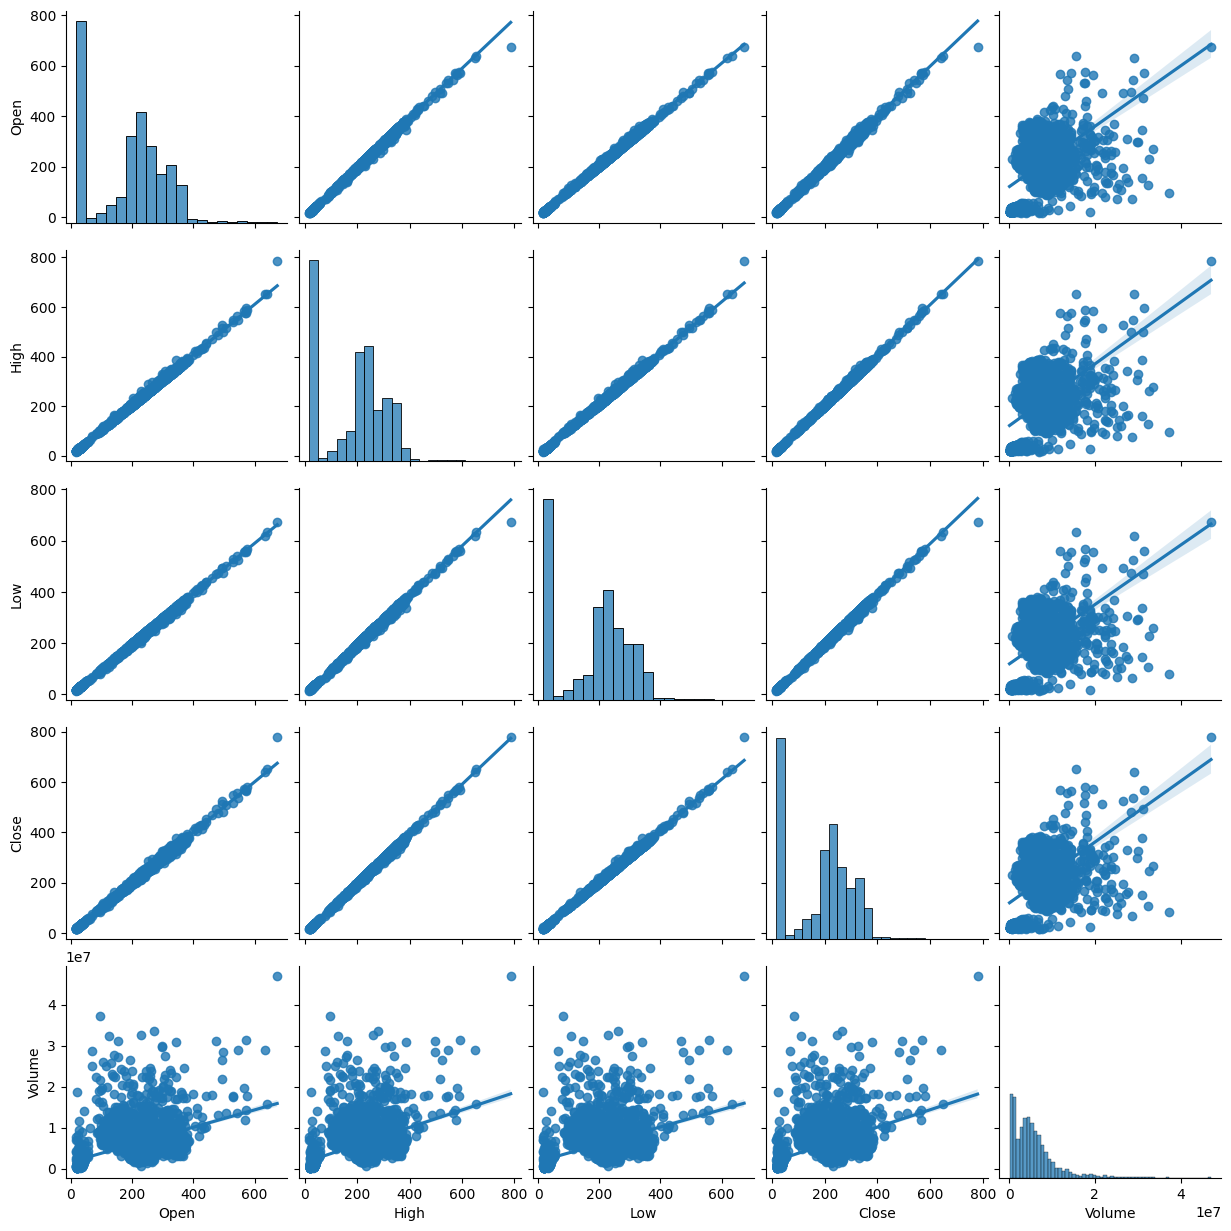

In [9]:
sns.pairplot(df, kind = "reg")

Із наведених графіків і так стає очевидно, що перші 4 характеристики повністю описуються лінійними залежностями, тому прогнозувати будемо об'єм торгів(Value)

### 2.2 Розділення даних на набори

In [14]:
from sklearn.model_selection import train_test_split
x = df.drop(columns = "Volume").values
y = df['Volume'].values
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=1, train_size=0.8)

### 2.3 Побудова моделей

In [15]:
from sklearn.svm import SVR

linModel = SVR(kernel='linear')
polyModel = SVR(kernel="poly")
rbfModel = SVR(kernel="rbf")

models = [linModel, polyModel, rbfModel]

for model in models:
    model.fit(xtrain, ytrain)

### 2.4 Прогнози на побудованих моделях

In [16]:
train_preds = []
test_preds = []
for model in models:
    train_preds.append(model.predict(xtrain))
    test_preds.append(model.predict(xtest))

### 2.5 Визначення метрик

In [17]:
from math import ceil
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def print_result(models, train_preds, val_pred, y_train, y_val, with_model_names = True):
 
    metrics = [r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error]
    metrics_values = []
    for i in range(len(models)):
        lst = []
        for metric in metrics:
            lst.append(metric(ytrain, train_preds[i]))
            lst.append(metric(ytest, test_preds[i]))
        metrics_values.append(lst)

    for i in range(len(models)):
        if with_model_names:
            n = ceil( (35 - len(str(models[i])))/2 )
            print("-"*n + str(models[i]) + "-"*n)
        print(" train_set test_set")
        print("R^2:" + " "*6 + f"{round(metrics_values[i][0],5)}" + " "*7 + f"{round(metrics_values[i][1], 4)}")
        print("MAE:" + " "*6 + f"{round(metrics_values[i][2],5)}" + " "*7 + f"{round(metrics_values[i][3], 4)}")
        print(f"MAPE:" + " "*5 + f"{round(metrics_values[i][4],5)}" + " "*7 + f"{round(metrics_values[i][5], 4)}")
        len_ = 7 + 7 - len(str(round(np.sqrt(metrics_values[i][4]), 4)))
        print(f"RMSE:" + " "*5 + f"{round(np.sqrt(metrics_values[i][6]), 4)}" + " "*len_ + 
           f"{round(np.sqrt(metrics_values[i][7]), 4)}")
        print()
        
 
 
print_result(models, train_preds, test_preds, ytrain, ytest)

--------SVR(kernel='linear')--------
 train_set test_set
R^2:      0.1944       0.1835
MAE:      2477925.62919       2609365.0179
MAPE:     0.47909       0.4816
RMSE:     4378316.3165        4859734.1874

---------SVR(kernel='poly')---------
 train_set test_set
R^2:      -0.02547       -0.0129
MAE:      3341363.78986       3429069.0726
MAPE:     1.489       1.439
RMSE:     4939788.4375        5412863.8624

---------------SVR()---------------
 train_set test_set
R^2:      -0.04002       -0.0375
MAE:      3380607.97546       3471563.5228
MAPE:     1.52502       1.4736
RMSE:     4974714.1045        5478272.3011



### 2.6 Решітчастий пошук для налаштування гіперпараметрів моделей

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid_for_svr_linear = {"C": [0.1, 0.5, 1, 5, 10, 100], 
    "epsilon": [1e-2, 0.1, 0.5, 1, 5]}
param_grid_for_svr_rbf = {"C": [0.1, 0.5, 1, 5, 10, 100],
    "epsilon": [1e-2, 0.1, 0.5, 1, 5]
}
param_grid_for_svr_poly = {"C": [0.1, 0.5, 1, 5, 10, 100],
    "epsilon": [1e-2, 0.1, 0.5, 1, 5], 
        "degree": [2, 3, 5, 10]
}
gs_svr_linear = GridSearchCV(linModel, param_grid_for_svr_linear, cv = 3,
    scoring = "neg_root_mean_squared_error")
gs_svr_rbf = GridSearchCV(rbfModel, param_grid_for_svr_rbf,
    scoring = "neg_root_mean_squared_error")
gs_svr_poly = GridSearchCV(polyModel, param_grid_for_svr_poly,
    scoring = "neg_root_mean_squared_error")


In [19]:
def dict_sort(dict_, k = -1):

    dict_ = {"params": dict_["params"],
        "mean_test_score": k*dict_["mean_test_score"]}

    sorted_dict = {"params" : [],
        "mean_test_score": []}
    # сортуємо у порядку спадання:
    sorted_score_values = np.sort(dict_["mean_test_score"])
    for value in sorted_score_values:
        index = np.where(dict_["mean_test_score"] == value)[0][0]
        sorted_dict["params"].append(dict_["params"][index])
        sorted_dict["mean_test_score"].append(dict_["mean_test_score"][index])

    return sorted_dict

# функція для виводу результату решітчатого пошуку
def print_gs_results(results, first = -1, k = -1):

    gs_info = {"params": results['params'],
        "mean_test_score": results['mean_test_score'],}

    gs_info = dict_sort(gs_info, k)
    size = results["mean_test_score"].shape[0]

    for i in range(size):
        str_ = str(gs_info['params'][i])
        n = len(str_)
        spaces = (45 - n)*" "
        print(gs_info['params'][i], spaces, round(gs_info['mean_test_score'][i],4))

        # зупинка виводу, якщо задано параметр first
        if i == first - 1:
            break

### 2.6.1 Решітчастий пошук для SVR(kernel = 'linear')

In [20]:
gs_svr_linear.fit(xtrain, ytrain)
print_gs_results(gs_svr_linear.cv_results_, first = 9)

{'C': 100, 'epsilon': 0.01}                    4147664.339
{'C': 100, 'epsilon': 0.1}                     4147664.3431
{'C': 100, 'epsilon': 0.5}                     4147664.3613
{'C': 100, 'epsilon': 1}                       4147664.3841
{'C': 100, 'epsilon': 5}                       4147664.566
{'C': 10, 'epsilon': 0.01}                     4349261.7514
{'C': 10, 'epsilon': 0.1}                      4349261.7543
{'C': 10, 'epsilon': 0.5}                      4349261.7675
{'C': 10, 'epsilon': 1}                        4349261.7839


### 1.6.2 Решітчастий пошук для SVR(kernel = "poly")

In [ ]:
gs_svr_poly.fit(xtrain, ytrain)
print_gs_results(gs_svr_poly.cv_results_, first = 9)

### 1.6.3 Решітчастий пошук для SVR(kernel = "rbf")

In [ ]:
gs_svr_rbf.fit(xtrain, ytrain)
print_gs_results(gs_svr_rbf.cv_results_, first = 9)